In [3]:
import jax
from jax.numpy.fft import fft, ifft
import jax.numpy as jnp
import matplotlib.pyplot as plt  
from jax import grad, vmap


import sys
root = '/home/emastr/github/phd/projects/vahid_project/'
sys.path.append('..')
sys.path.append(f'{root}src/')
sys.path.append(f'{root}util/')
sys.path.append(f'{root}data/')
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion

def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift
# Use finite difference hessian for stepping.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0 (5, 0, 0) shift 180 from true: [0 0 0 0 0] angles:  [0. 0. 0. 0. 0.] eigs [0.16, 0.2, 0.19, 0.18, 0.17]
1 (3, 0, 2) shift 180 from true: [0 0 0 0 1] angles:  [0.        0.        0.        0.        3.1415927] eigs [0.15, 0.09, 0.01, -0.07, -0.05]
2 (3, 0, 2) shift 180 from true: [0 0 0 1 0] angles:  [0.        0.        0.        3.1415927 0.       ] eigs [0.13, 0.1, 0.02, -0.06, -0.05]
3 (3, 0, 2) shift 180 from true: [0 0 0 1 1] angles:  [0.        0.        0.        3.1415927 3.1415927] eigs [-0.19, 0.16, -0.0, 0.07, 0.1]
4 (3, 0, 2) shift 180 from true: [0 0 1 0 0] angles:  [0.        0.        3.1415927 0.        0.       ] eigs [0.14, 0.1, -0.08, -0.05, 0.01]
5 (1, 0, 4) shift 180 from true: [0 0 1 0 1] angles:  [0.        0.        3.1415927 0.        3.1415927] eigs [0.12, -0.17, -0.02, -0.04, -0.11]
6 (1, 0, 4) shift 180 from true: [0 0 1 1 0] angles:  [0.        0.        3.1415927 3.1415927 0.       ] eigs [0.12, -0.14, -0.1, -0.01, -0.

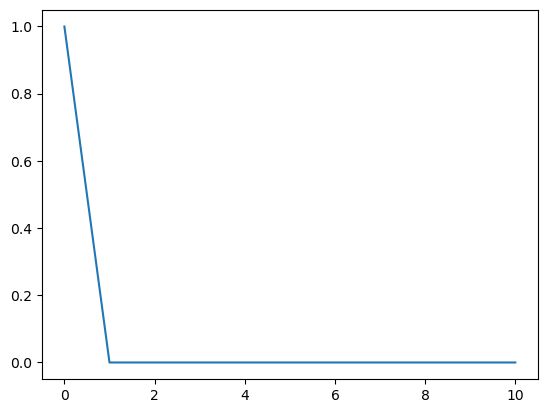

In [4]:
import math
outer = lambda x, y: jnp.einsum('i,j->ij', x.conj(), y)
inner = lambda x, y: jnp.einsum('i,i->', x.conj(), y)
diff = lambda x: (x - jnp.roll(x, len(x)//10))/float(len(x)//10)*float(len(x))

Lhalf = 5
L = 2*Lhalf + 1
t = jnp.linspace(0, 2*jnp.pi, L+1)[:-1]
f = lambda t: t == 0. #> jnp.pi
#f = lambda t: t> jnp.pi
stdev = 1.#0.01
N = 200000
x = f(t)
y, noise, shift = get_samples(random.PRNGKey(4), x, stdev, N)

xfft = fft(x)
xfft_abs = jnp.abs(xfft)
xfft0 = xfft[0]
yfft = fft(y, axis=1)    
#ymean, yauto_fft, _ = invariants_from_data(y, stdev)
    
    
def to_xfft(angles, xfft_abs, xfft0):
    angles = jnp.concatenate([angles, -angles[::-1]])
    xfft = jnp.concatenate([jnp.array([xfft0]), jnp.exp(1j * angles) * xfft_abs[1:]])
    return xfft 

def shift_fft(shift, xfft):
    angles = jnp.angle(xfft[1:Lhalf+1])
    xfft = to_xfft(angles+shift, jnp.abs(xfft), xfft[0])
    return xfft
    
def loss(xfft):
    return loss_fft(xfft, yfft)

def loss_angle(angle, xfft_abs, xfft0):
    xfft = to_xfft(angle, xfft_abs, xfft0)
    return loss(xfft)

def e(i):
    e = jnp.zeros(Lhalf)
    e = e.at[i].set(1.)
    return e

def hessian_angle(angle, xfft_abs, xfft0, h=1e-3):
    L = lambda a: loss_angle(a, xfft_abs, xfft0)
    def ddL(a, i, j):
        ddL_val = 0.
        for p in [-h, h]:
            for q in [-h, h]:
                ddL_val += L(a + p*e(i) + q*e(j))/(p*q)
        return ddL_val
    #ddL = lambda a, i, j: L(a + h*e(i) + h*e(j)) - L(a + h*e(i) - h*e(j)) - L(a - h*e(i) + h*e(j)) + L(a -h*e(i)-h*e(j))
    hes = jnp.zeros((Lhalf, Lhalf))
    for i in range(Lhalf):
        for j in range(Lhalf):
            hes = hes.at[i, j].set(ddL(angle, i, j))
    return hes

def compute_index(hes, tol=1e-3):
    eigvals = jnp.linalg.eigvals(hes).real
    num_pos = (eigvals > tol).sum()
    num_neg = (eigvals < -tol).sum()
    num_zero = len(eigvals) - num_pos - num_neg
    return (int(num_pos), int(num_zero), int(num_neg))
    

def compute_index2(angle, xfft_abs, xfft0, h=1e-3):
    L = lambda a: loss_angle(a, xfft_abs, xfft0)
    dL = lambda a, i: L(a + h*e(i)) - L(a)
    gradL = jnp.array([dL(angle, i) for i in range(Lhalf)])
    return (int((gradL > 0).sum()), int((gradL == 0).sum()), int((gradL < 0).sum()))

def test_phase_combos(angles, xfft_abs, xfft0):
    morse = 0
    crit = jnp.zeros(Lhalf+1, dtype=int)
    for it in range(2**Lhalf):
        shift = [int(i) for i in bin(it)[2:]]
        shift = jnp.array([0]*(Lhalf-len(shift)) + shift)
        #angles_shift = angles
        angles_shift = angles + jnp.pi * shift
        hes = hessian_angle(angles_shift, xfft_abs, xfft0, h=3e-1)#1e-2)
        index = compute_index(hes, 0.001)#1e-2)
        #index2 = compute_index2(angles_shift, xfft_abs, xfft0, h=1e-2)
        crit = crit.at[index[-1]].set(int(crit[index[-1]] + 1))
        print(it, index, "shift 180 from true:", shift, "angles: ", angles_shift, "eigs", [float(f"{e:.2f}") for e in jnp.linalg.eigvals(hes).real])#, index2)
        morse += (-1)**index[-1]
    print(f"Morse Index Theorem: {morse}")
    for i in range(Lhalf+1):
        print(f"Index {i}: count {crit[i]}, lower bound {math.comb(Lhalf, i)}")
    return morse
        
        
angles = jnp.angle(xfft[1:Lhalf+1])
print(xfft_abs)
print(test_phase_combos(angles, xfft_abs, xfft0))
plt.plot(ifft(xfft).real) 

    